splitting spectrogram images into train test  

In [62]:
import os
import torch
import torch.nn as nn
import splitfolders
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# ratio = (training, validation, testing)
# splitfolders.ratio("C:\\Users\\vinay\\Downloads\\FEIS_v1_1\\spectrogram\\", output="C:\\Users\\vinay\\Downloads\\FEIS_v1_1\\spectrogram_train_test_split\\", seed=1337, ratio=(.8, 0, .2), group_prefix=None, move=False)

In [64]:
# dataset directory
data_dir = 'C:\\Users\\vinay\\Downloads\\FEIS_v1_1\\spectrogram_train_test_split_resized\\'
classes = os.listdir(data_dir + "\\train")

In [65]:
# Since the dataset is in PIL we convert to tensor to perform operation
dataset = ImageFolder(data_dir+'\\train', transform = ToTensor())
print(dataset.classes)

['f', 'fleece', 'goose', 'k', 'm', 'n', 'ng', 'p', 's', 'sh', 't', 'thought', 'trap', 'v', 'z', 'zh']


In [66]:
dataset

Dataset ImageFolder
    Number of datapoints: 1280
    Root location: C:\Users\vinay\Downloads\FEIS_v1_1\spectrogram_train_test_split_resized\\train
    StandardTransform
Transform: ToTensor()

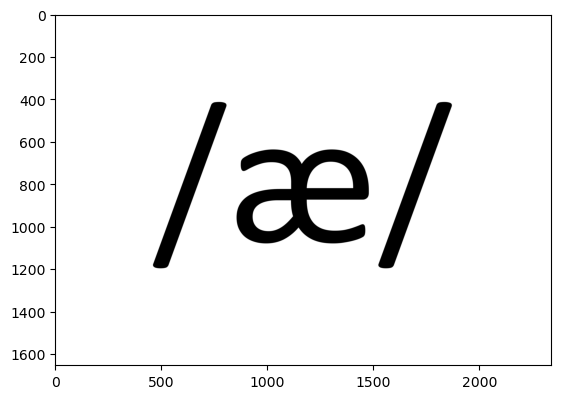

In [67]:
import cv2
import matplotlib.pyplot as plt
# read an image
img1 = cv2.imread('C:\\Users\\vinay\\Downloads\\FEIS_v1_1\\imgs\\trap.png')
plt.imshow(img1)
plt.show()

Label: f (0)
torch.Size([3, 32, 32])


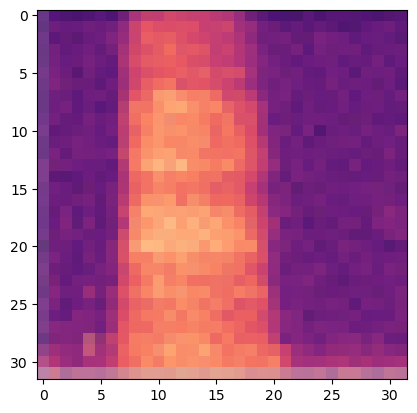

In [68]:
# displaying sample image from dataset
def show_example(img,label):
    print('Label:', dataset.classes[label], "("+str(label)+")")
    print(img.size())
    plt.imshow(img.permute(1,2,0))
    plt.show()

show_example(*dataset[0])

In [69]:
# Splitting training data into batches
batchsize = 8

train_dl = DataLoader(dataset, batchsize, shuffle=True, num_workers=2, pin_memory=True)

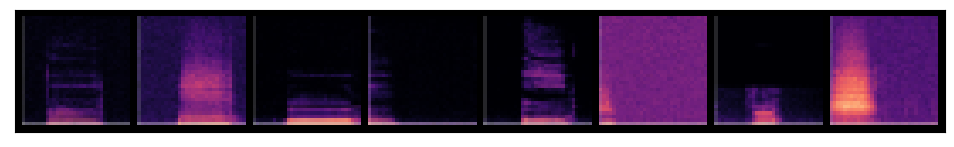

In [70]:
# displaying one batch of images
def show_batch(dl):
    for images, label in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [71]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'loss': loss, 'acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result['train_loss'], result['train_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [72]:
class Cifar10CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,16)
        )
    def forward(self, xb):
        return self.network(xb)

model = Cifar10CNNModel()

In [73]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [74]:
device = get_default_device()
device

device(type='cpu')

In [75]:
train_dl = DeviceDataLoader(train_dl, device)
to_device(model, device);

In [85]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval() # testing the model
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr) # explicitly telling it what parameters (tensors) of the model it should be updating i.e. weight and biases
    for epoch in range(epochs):
        #training phase
        model.train() # tells your model that you are training the model; model.eval() or model.train(mode=False) to tell that you are testing.
        train_losses = []
        train_acc = []
        result = {}
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward() # The gradients are "stored" by the tensors themselves once called backward on the loss
            optimizer.step() # makes the optimizer iterate over all parameters it is supposed to update and use their internally stored grad to update their values.
            optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor's to zero.
        #validation phase
        #result = evaluate(model, train_loader)
        result['epoch'] = epoch
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [77]:
model = to_device(Cifar10CNNModel(), device)

In [78]:
#evaluate(model, val_dl)

In [79]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

Feature batch shape: torch.Size([8, 3, 32, 32])
Labels batch shape: torch.Size([8])
tensor([12, 10,  7,  1,  5,  9, 13,  5])
tensor([[[0.6627, 0.6510, 0.6588,  ..., 0.5882, 0.6667, 0.6667],
         [0.6471, 0.6510, 0.6275,  ..., 0.6941, 0.6863, 0.6784],
         [0.6667, 0.6510, 0.6392,  ..., 0.6706, 0.6784, 0.6784],
         ...,
         [0.9255, 0.9882, 0.9647,  ..., 0.6510, 0.6196, 0.6588],
         [0.9255, 0.9843, 0.9451,  ..., 0.6667, 0.6235, 0.6471],
         [0.8431, 0.8627, 0.8431,  ..., 0.7490, 0.7098, 0.7373]],

        [[0.2980, 0.1961, 0.1961,  ..., 0.1765, 0.2000, 0.2000],
         [0.2941, 0.1961, 0.1843,  ..., 0.2118, 0.2078, 0.2039],
         [0.2980, 0.1922, 0.1882,  ..., 0.2000, 0.2039, 0.2039],
         ...,
         [0.4863, 0.6980, 0.6431,  ..., 0.1922, 0.1843, 0.1961],
         [0.5137, 0.6431, 0.5333,  ..., 0.2000, 0.1843, 0.1922],
         [0.5922, 0.5843, 0.5843,  ..., 0.4549, 0.4392, 0.4510]],

        [[0.5451, 0.4745, 0.4784,  ..., 0.4745, 0.4745, 0.4784]

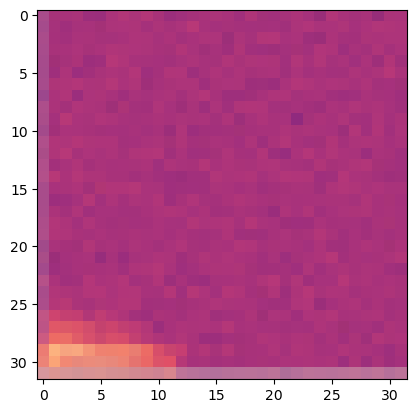

Label: 12


In [80]:
# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_labels)
img = train_features[0].squeeze()
print(img)
label = train_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {label}")

In [81]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [86]:
history = fit(num_epochs, lr, model, train_dl, opt_func)

Epoch [0], train_loss: 1.5697, train_acc: 0.4102
Epoch [1], train_loss: 1.2894, train_acc: 0.5086
Epoch [2], train_loss: 1.0216, train_acc: 0.5961
Epoch [3], train_loss: 0.7998, train_acc: 0.6578
Epoch [4], train_loss: 0.7214, train_acc: 0.6922
Epoch [5], train_loss: 0.6303, train_acc: 0.7281
Epoch [6], train_loss: 0.5248, train_acc: 0.7711
Epoch [7], train_loss: 0.5290, train_acc: 0.7773
Epoch [8], train_loss: 0.5243, train_acc: 0.8047
Epoch [9], train_loss: 0.3872, train_acc: 0.8414


In [87]:
history

[{'epoch': 0, 'train_loss': 1.5697038173675537, 'train_acc': 0.41015625},
 {'epoch': 1, 'train_loss': 1.289358139038086, 'train_acc': 0.508593738079071},
 {'epoch': 2,
  'train_loss': 1.0215940475463867,
  'train_acc': 0.5960937738418579},
 {'epoch': 3,
  'train_loss': 0.7997597455978394,
  'train_acc': 0.6578124761581421},
 {'epoch': 4,
  'train_loss': 0.7213849425315857,
  'train_acc': 0.692187488079071},
 {'epoch': 5,
  'train_loss': 0.630297064781189,
  'train_acc': 0.7281249761581421},
 {'epoch': 6,
  'train_loss': 0.5247837901115417,
  'train_acc': 0.7710937261581421},
 {'epoch': 7, 'train_loss': 0.5290294885635376, 'train_acc': 0.77734375},
 {'epoch': 8, 'train_loss': 0.5243419408798218, 'train_acc': 0.8046875},
 {'epoch': 9,
  'train_loss': 0.38717007637023926,
  'train_acc': 0.8414062261581421}]

In [88]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history)
# save to csv: 
hist_csv_file = './model_history/model_acc_loss_3.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False, line_terminator='\n')

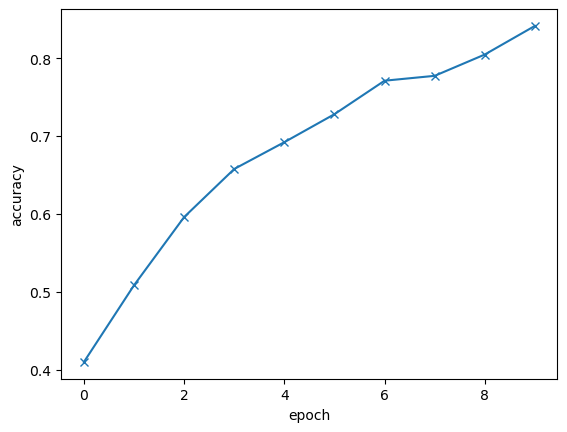

In [89]:
def plot_accuracies(history):
    accuracies = [x['train_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    #plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

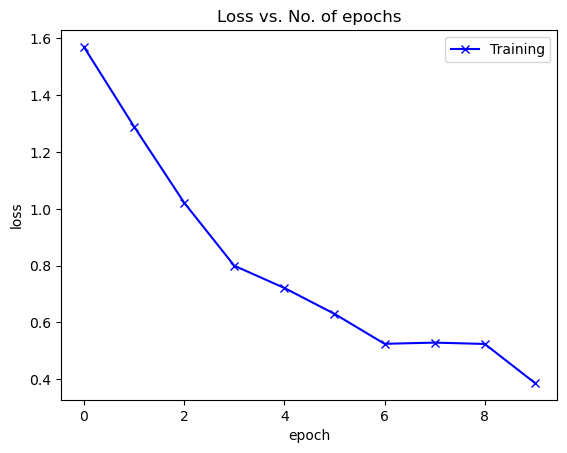

In [90]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    #val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    #plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

In [91]:
test_dataset = ImageFolder(data_dir+'\\test', transform=ToTensor())

In [92]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: k , Predicted: k


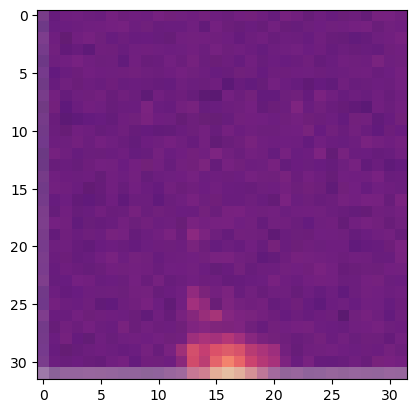

In [93]:
img, label = test_dataset[60]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [94]:
test_dl = DataLoader(test_dataset, batchsize, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(train_dl, device)
result = evaluate(model, test_dl)

In [95]:
print("test data loss and accuracy is", result)

test data loss and accuracy is {'loss': 0.40106338262557983, 'acc': 0.840624988079071}
